<a href="https://colab.research.google.com/github/ROPANZ/fds/blob/master/FourierROM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#Installs
!pip install line_profiler
!pip install pylops

In [0]:
# Imports
import itertools as it
import numpy as np
from numpy import arange,meshgrid,sqrt
#np.seterr(divide='ignore', invalid='ignore')
import scipy as sp
import scipy.signal as sps
from scipy import signal
from scipy.sparse.linalg import lsmr
from scipy.sparse.linalg import lsqr
#from scipy.sparse.linalg import LinearOperator
from pylops import LinearOperator
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl 
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
#Play Mp4s
import matplotlib.animation as animation
from IPython.display import HTML
from base64 import b64encode
# Matplotlib inline
import time
import pylab as pl
from IPython import display
#########
import os
from google.colab import drive
from google.colab import files

In [3]:
# Montar Google Drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [4]:
# Set homepath and check files in the directory 
homepath = './gdrive/My Drive/Docs Drive/PUC/MagisterDrive/ColabPython'
simspath = './gdrive/My Drive/Docs Drive/PUC/MagisterDrive/ColabPython/Sims'
!pwd
files = os.listdir(homepath)
os.chdir(homepath)
print(files)

/content
['NSROM.ipynb', 'Sims', 'RFM.ipynb', 'USROM.ipynb', 'FourierROM.ipynb']


# Code structure
Every function is handled in its Fourier coefficients with the following structure.
If $$f:\mathbb{R}^n\rightarrow\mathbb{R}^m$$ then the array containing the Fourier coefficients of f have the following shape: (m,n-dimensional coefficients with C order (last index varying faster)).
It remains making explicit the assumtions of the model




In [0]:
# Auxiliary Functions

def invfourier(x,opt,d):
# Inverse Fourier function for an n-dimensional input with shape (dim,fourier coefficients n-dimensional arranged with C order)
# The opt parameters allows to select normal ifft, zero padding of d-order with opt='z' and a low resolution subsampled ifft with 
# parameter d that uses d times the resolution for the padding
    if opt == 'z':
        FS2 = zeropad(x,d)
        Xr = np.prod(FS2.shape[1:])*np.fft.ifftn(FS2,axes=range(1,dim+1))
    elif opt == 'l':
        diminput = x.shape[0]
        FS2 = np.reshape(x,np.concatenate(([diminput],coefs))) 
        PreXr = np.prod(FS2.shape[1:])*np.fft.ifftn(FS2,axes=range(1,dim+1))
        if dim == 2:            
            Xr = PreXr[:,::d,::d]
        elif dim == 3:
            Xr = PreXr[:,::d,::d,::d]
    else:
        diminput = x.shape[0]
        FS2 = np.reshape(x,np.concatenate(([diminput],coefs))) 
        Xr = np.prod(FS2.shape[1:])*np.fft.ifftn(FS2,axes=range(1,dim+1))
    return Xr


def zeropad(x,padd):
    diminput = x.shape[0]
    FS2 = np.fft.fftshift(np.reshape(x,np.concatenate(([diminput],coefs))),axes=range(1,dim+1))
    y = np.concatenate(([0],(2*padd*np.array(res[:dim]))))
    FS3 = np.zeros(np.array(np.array(FS2.shape,np.int16)+y,np.int16),np.complex64)
    if dim == 2:
        FS3[:,padd*res[0]:(FS2.shape[1]+res[0]*padd),padd*res[1]:(FS2.shape[2]+padd*res[1])] = FS2        
    elif dim == 3:
        FS3[:,padd*res[0]:(FS2.shape[1]+padd*res[0]),padd*res[1]:(FS2.shape[2]+padd*res[1]),padd*res[2]:(FS2.shape[3]+padd*res[2])] = FS2 
    out = np.fft.ifftshift(FS3,axes=range(1,dim+1))
    return out#.reshape((diminput,np.prod(out.shape[1:])))

def FejerKernel(x,c,dim):
# Fejer Kernel normalized function Fourier coefficients
# Inputs: the indexes x, c is the number parameter for the function and the dimension dim 
    temp = np.prod(np.multiply(np.exp(-1j*x*L/2),np.maximum(1-abs(x/(2*np.pi/L))/c,0))/c,axis=0)
    func = np.outer(np.ones((1,dim)), temp)
    return func

def fsourcenumeric(x,y,t):
# Numeric form of the source for an analytic solution used in "Numerical solution of buoyancy-driven flow problems" by Einar Rossebo
# Inputs: X,Y meshgrid and t the time 
    fx = np.sin(2*np.pi*y)*(2*np.pi**3*np.sin(t)+np.pi*np.cos(t)/2) \
    -np.cos(2*np.pi*x)*np.sin(2*np.pi*y)*(4*np.pi**3*np.sin(t)+np.pi*np.cos(t)/2) \
    -np.pi*np.sin(np.pi*x)*np.sin(np.pi*y)*np.sin(t)
    fy = np.sin(2*np.pi*y)*(2*np.pi**3*np.sin(t)+np.pi*np.cos(t)/2) \
    - np.cos(2*np.pi*x)*np.sin(2*np.pi*y)*(4*np.pi**3*np.sin(t)+np.pi*np.cos(t)/2)
    -np.pi*np.sin(np.pi*x)*np.sin(np.pi*y)*np.sin(t)
    return np.array([fx.T,fy.T])

def vecindex(n):
# Index vector acording to numpy fft, n is the number of the coefficients used
# Inputs: n: number for the vector 
    return np.concatenate((np.arange(n+1),np.arange(-n,0)),axis = None)

def genindexes(d): 
# Inputs: dimension number d
    if d==2:
        out = (2*np.pi/L)*np.array([(i,j) for i in vecindex(res[0]) for j in vecindex(res[1])],np.int8)
    elif d==3:
        out = (2*np.pi/L)*np.array([(i,j,k) for i in vecindex(res[0]) for j in vecindex(res[1]) for k in vecindex(res[2])],np.int8)
    return out.T

# Model parameters


In [0]:
# General physics parameters (dry air)
g = 9.81           # Gravity constant
rhom = 1.177       # Mean density
R = 287.058        # Specific gas constant
Tm = 296.16        # Ambient and equilibrium tamperature
mu = 1.846e-5      # Dynamic viscosity 
kappa = 2.229e-2   # Specific thermal conductivity
cv = 717.4         # Specific heat capacity
cp = cv + R        # Specific heat const. pressure
num = mu/rhom      
l = 8.6e3          # Characteristic length

# Nondimensional test parameters
rhom = 1           # Mean density
mu = 1             # Dynamic viscosity 
num = mu/rhom      
l = 8.6e3          # Characteristic length

# Case study parameters
L = 1                 # Characteristic length
gamma = kappa/cp      # Non-dimensionalization parameter
beta = 1/Tm        # Beta parameter Boussinesq
#Ra = g*beta*Tm*L**3/(gamma*num)  # Rayleigh number
Ra = 1e6                          # Rayleigh number
Pr = num/gamma                    # Prandtl number
Ca = (L*rhom)/(l*(1-np.exp(-L/l))) 
Td = gamma**3/(L**2*Tm)           # "To define" (Peclet?) number

# Source parameters (intensity)
q = 1e-2      # Heat inflow
f = 1    # Momentum inflow

# Simulation parameters
dim = 2         # Dimension
t = 1e-4           # Initial time of simulation 
dt = 5e-4       # Delta t 
tend = 200*dt        # Time of simulation
res = (32,32,32)   # Resolution in Fourier coefficients
indexes = genindexes(dim)
coefs = np.array([(2*i+1) for i in res[:dim]])
combs = np.prod(coefs)
dx = L/np.array(coefs)
#N = 6           # Smoothed convolution parameter

# Operator functions

---



In [0]:
chisq = np.sum(np.square(indexes),axis=0).reshape((1,indexes.shape[1]))

# Time-independent linear operators
def Muu():
    return -Pr*chisq*u

def Mup():
    return -1j*indexes*p

def Mtt():
    return -chisq*T

# Time-independent bilinear operators

def Bt(x):
    phieta = x*indexes
    conv = np.sum(sps.convolve(phieta,u,mode='same')/dx.reshape(dim,1),axis=0)
    return conv.reshape(1,conv.shape[0])

def Bu(x):
    mat = np.array([Bt(x[i,:])[0,:] for i in range(dim)])
    return mat

# Time-dependent linear operators

def Ltt(f):
    conv = -Td*sps.convolve(f[dim-1,:],u[dim-1,:],mode='same')/dx[dim-1]
    return conv.reshape((1,conv.shape[0]))


# Projection operators for the BC

---



In [0]:
# Linear maps

class Adiv(LinearOperator):
    r"""Divergence for Fourier Coefficients

    Compute the divergence in Fourier as the dot produt dot(\xi,vectorfield(\xi,t)) 

    Parameters
    ----------
    No parameters needed

    Attributes
    ----------
    shape : :obj:`tuple`
        Operator shape
    explicit : :obj:`bool`
        Operator contains a matrix that can be solved explicitly
        (``True``) or not (``False``)
    """
    def _init_(self, dtype='complex64'):
        self.shape = (1,dim)
        self.dtype = np.dtype(dtype)

    def _matmat(x):
        return np.sum(indexes*x,axis=0).reshape((1,indexes.shape[1]))

    def _rmatmat(x):
        return indexes*x

class AD(LinearOperator):
    r"""Linear map for Dirichlet boundary conditions

    Sum along i-axis of the Fourier coefficients of a vector field of dimension
    = dim 

    Parameters
    ---------- 
    axis : dimension in which the sum is made

    Attributes
    ----------
    shape : :obj:`tuple`
        Operator shape
    explicit : :obj:`bool`
        Operator contains a matrix that can be solved explicitly
        (``True``) or not (``False``)
    """
    def _init_(self,direction,dtype='complex64'):
        self.direction = direction
        self.shape = (1,dim)
        self.dtype = np.dtype(dtype)
        self.explicit = False

    def _matmat(x):
        x2 = x[self.axis,:]
        FS2 = np.sum(np.reshape(x2,np.concatenate(([1],coefs))),axis = self.axis)
        return np.reshape(FS2,np.concatenate(([1],[np.prod(coefs[np.arange(len(coefs))!= self.axis])])))
        
    def _rmatmat(x):
        st = np.zeros((dim,np.prod(coefs[np.arange(len(coefs))!= self.axis])))
        st[self.axis,:] = x
        return st

class AN(LinearOperator):
    r"""Linear map for Neumman boundary conditions

    Sum along i-axis of the Fourier coefficients of a vector field of dimension
    = dim 

    Parameters
    ---------- 
    axis : dimension in which the sum is made

    Attributes
    ----------
    shape : :obj:`tuple`
        Operator shape
    explicit : :obj:`bool`
        Operator contains a matrix that can be solved explicitly
        (``True``) or not (``False``)
    """
    def _init_(self,axis,dtype='complex64'):
        self.axis = axis
        self.shape = (1,dim)
        self.dtype = np.dtype(dtype)
        self.explicit = False

    def _matmat(x):
        diminput = x.shape[0]
        FS2 = np.sum(np.reshape(x,np.concatenate(([diminput],coefs))),axis = self.axis)
        return np.reshape(FS2,np.concatenate(([diminput],[np.prod(coefs[np.arange(len(coefs))!= self.axis])])))
        
    def _rmatmat(x):
        return indexes*x



# Macro simulating routines: boundary conditions and timestepping 

In [0]:
def project(x,operator): # Project solution to satisfy BC of the velocity
    diminput = x.shape[0]
    results = []
    for i in np.arange(diminput):
        results[i] = lsqr(operator,x[i,:])[:4]
    msj = ''
    directions = {0:'x',1:'y',2:'z'}
    tmp = 0
    for k in results:
        msj = msj + 'istop' + directions[tmp] +' = '+str(k[1]) + '; itn' + directions[tmp] +' = '+ str(k[2])+ '; norm' \
        + directions[tmp] +' = '+ str(k[3])+'\n'
        tmp = tmp + 1
    return (results[:,0],msj)

def PIU(x):
    return 0


def PIT(x): # Project solution to satisfy BC of the temperature 
    return 0


In [15]:
print(AD(4)*u.shape)

AttributeError: ignored

In [0]:
#def test(x,ax):
        #x2 = indexes[ax,:]*x
        #FS2 = np.sum(np.reshape(x2,np.concatenate(([1],coefs))),axis = ax)
        #return np.reshape(FS2,np.concatenate(([1],[np.prod(coefs[np.arange(len(coefs))!= ax])])))

def test(x,ax):
        st = np.zeros((dim,np.prod(coefs[np.arange(len(coefs))!= ax])),dtype = np.complex64)
        st[ax,:] = x
        return st

In [0]:
# Source function
#Q = np.transpose([qinitial(indexes)])
#Q =  np.zeros((combs,1),dtype=np.float32)  
#F = np.transpose([finitial(indexes)])

# Variables Initialization (initial condition)  
u = np.zeros((dim,combs),dtype=np.complex64)        # Zero initial velocity
T = np.zeros((1,combs),dtype=np.complex64)        # Constant initial temperature
T[0] = 1
p = np.zeros((1,combs),dtype=np.complex64)        # Constant initial pressure
p[0] = 0 # 101.325/(L*rhom*gamma**2)                # Atmospheric pressure
#p[0] = R*Tm*Ca*np.exp(-1.5/l)/(L*rhom*gamma**2)  # Calculated initial constant pressure 
#p = np.transpose([pinitial(indexes)])             # Exponential pressure gradient 

#Testing Section


(65, 65)
(65, 65)


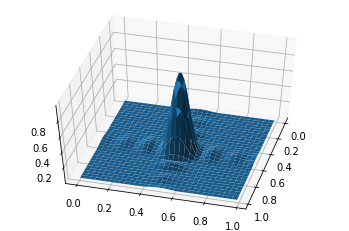

In [0]:
# Plot the surface
Z = invfourier(FejerKernel(indexes,7,1),None,0)[0,:].real
print(Z.shape)
[X, Y] = np.meshgrid(np.arange(0,L,L/(Z.shape[0])),np.arange(0,L,L/(Z.shape[1])))
print(X.shape)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=50., azim=15.)
surf = ax.plot_surface(X,Y,Z)
plt.draw()

(705, 705)
(705, 705)


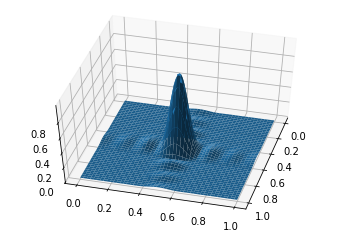

In [0]:
# Plot the surface
Z = invfourier(FejerKernel(indexes,7,2),'z',10)[0,:].real
print(Z.shape)
[X, Y] = np.meshgrid(np.arange(0,L,L/(Z.shape[0])),np.arange(0,L,L/(Z.shape[1])))
print(X.shape)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=50., azim=15.)
surf = ax.plot_surface(X,Y,Z)
plt.draw()

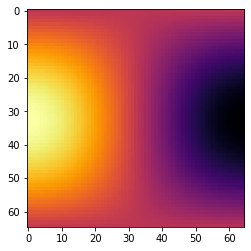

In [0]:
[X,Y] = np.meshgrid(np.arange(0,L,L/coefs[0]),np.arange(0,L,L/coefs[1]))
S = np.cos(np.pi*X)*np.sin(np.pi*Y)
plt.imshow(S,cmap=plt.cm.inferno)
plt.show()

In [0]:
FS = np.fft.fftn(S)
FS2 = FS.reshape(np.concatenate(([1],FS.shape)))
print(FS2.shape)

(1, 65, 65)


In [0]:
invfourier(FS2,'z',64).shape

(1, 193, 193)

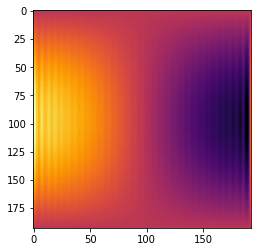

In [0]:
plt.imshow(invfourier(FS2,'z',64)[0,:].real,cmap=plt.cm.inferno)
plt.show()

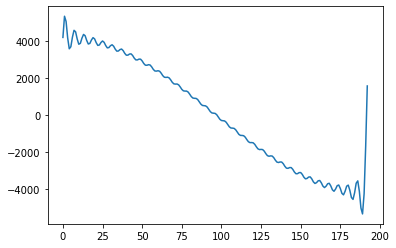

In [0]:
plt.plot(invfourier(FS2,'z',64)[0,100,:].real)
plt.show()

In [0]:
np.array_equal(invfourier(FejerKernel(indexes,7,2))[0,:],invfourier(FejerKernel(indexes,7,2))[1,:])

TypeError: ignored

Text(0.5, 0, 'Sample')

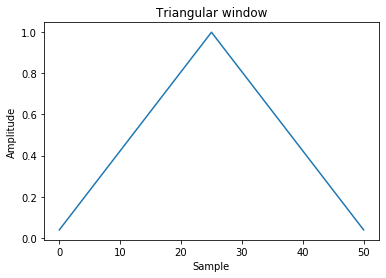

In [0]:
window = signal.triang(51,sym=True)
plt.plot(window)
plt.title("Triangular window")
plt.ylabel("Amplitude")
plt.xlabel("Sample")

[-1, 1, 0, 0.7]

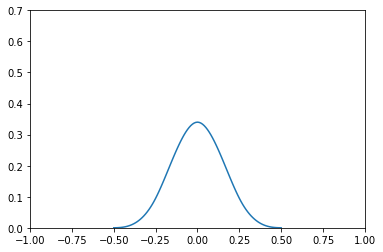

In [0]:
plt.figure()
A = signal.triang(51)
response = sps.convolve(A,A)*1/len(A)
freq = np.linspace(-0.5, 0.5, len(response))
plt.plot(freq, response)
plt.axis([-1, 1, 0, 0.7])

In [0]:
test = np.arange(8).reshape((2,4))
print(test)
print(np.arange(0,8,2))
print(test*np.arange(0,8,2).reshape((1,4)))

[[0 1 2 3]
 [4 5 6 7]]
[0 2 4 6]
[[ 0  2  8 18]
 [ 0 10 24 42]]
